# Sea Surface Temperature (SST) Analysis - MUR L4 Data

This notebook demonstrates processing and visualization of MUR L4 Sea Surface Temperature data using the L3 pipeline. Based on principles from the combined CDOM-SST analysis but focused solely on SST visualization.

**Pipeline Steps:**

1. **Import libraries** and set up the environment.
2. **Define constants and parameters** for SST processing and geographical bounding box.
3. **SST Processing:**
   * Search for and load MUR L4 SST NetCDF files using L3 pipeline.
   * Inspect SST data structure.
   * Extract and process SST data.
   * Convert from Kelvin to Celsius and apply quality thresholds.
4. **SST Visualization:**
   * Plot raw SST data with oceanographic colormap.
   * Include coastlines, gridlines, and proper cartographic projection.

### Library Imports

Import essential libraries for file handling, numerical operations, plotting, and custom processing.

In [1]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean  # For specialized oceanographic colormaps

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))  # adds project_root to path

# Import L3 pipeline for MUR L4 data processing
from pipelines.l3_pipeline import L3DatasetLoader

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

### Define Constants and Parameters

Define constants for SST processing, geographical area, and data paths.

In [2]:
# --- Geographical Parameters ---
# Texas-Louisiana Shelf region
lon_min, lon_max = -94.0, -88.0
lat_min, lat_max = 27.5, 30.5

# --- MUR L4 SST Data Configuration ---
data_dir_mur_l4 = r"E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2024-06-01_2024-06-30"
mur_l4_variable = 'analysed_sst'

# --- Quality Control Thresholds ---
min_sst_celsius_threshold = -2.0  # Minimum reasonable SST in Celsius
max_sst_celsius_threshold = 35.0  # Maximum reasonable SST in Celsius

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"MUR L4 Data Directory: {data_dir_mur_l4}")
print(f"SST Variable: {mur_l4_variable}")
print(f"Temperature Range Thresholds: {min_sst_celsius_threshold}°C to {max_sst_celsius_threshold}°C")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
MUR L4 Data Directory: E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2024-06-01_2024-06-30
SST Variable: analysed_sst
Temperature Range Thresholds: -2.0°C to 35.0°C


## MUR L4 SST Data Processing

### Search for MUR L4 SST Files

In [3]:
# Search for MUR L4 NetCDF files
mur_l4_files = glob.glob(os.path.join(data_dir_mur_l4, '*.nc'))

if not mur_l4_files:
    print(f"Warning: No MUR L4 files found in {data_dir_mur_l4}")
else:
    print(f"Found {len(mur_l4_files)} MUR L4 files.")
    
# Optionally limit files for testing
# mur_l4_files = mur_l4_files[:3]  # Use only first 3 files for quick testing
# print(f"Using {len(mur_l4_files)} MUR L4 files for processing.")

Found 31 MUR L4 files.


### Inspect MUR L4 Data Structure

In [4]:
# Inspect the structure of the first MUR L4 file
if mur_l4_files:
    print(f"Inspecting variables in the first MUR L4 file: {os.path.basename(mur_l4_files[0])}")
    try:
        with xr.open_dataset(mur_l4_files[0]) as ds:
            print(f"\nDataset dimensions:")
            for dim_name, dim_size in ds.dims.items():
                print(f"  {dim_name}: {dim_size}")
            
            print(f"\nMain data variables:")
            for var_name in ds.data_vars:
                var_obj = ds[var_name]
                print(f"  {var_name}: {var_obj.shape} - {var_obj.long_name if 'long_name' in var_obj.attrs else 'No description'}")
                if hasattr(var_obj, 'units'):
                    print(f"    Units: {var_obj.units}")
            
            print(f"\nCoordinate variables:")
            for coord_name in ds.coords:
                coord_obj = ds.coords[coord_name]
                if coord_name not in ds.dims:  # Don't repeat dimension coords
                    print(f"  {coord_name}: {coord_obj.shape}")
                    
    except Exception as e:
        print(f"Error inspecting MUR L4 file: {e}")
else:
    print("No MUR L4 files found to inspect.")

Inspecting variables in the first MUR L4 file: 20240601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc

Dataset dimensions:
  time: 1
  lat: 17999
  lon: 36000

Main data variables:
  analysed_sst: (1, 17999, 36000) - analysed sea surface temperature
    Units: kelvin
  analysis_error: (1, 17999, 36000) - estimated error standard deviation of analysed_sst
    Units: kelvin
  mask: (1, 17999, 36000) - sea/land field composite mask
  sea_ice_fraction: (1, 17999, 36000) - sea ice area fraction
  dt_1km_data: (1, 17999, 36000) - time to most recent 1km data
  sst_anomaly: (1, 17999, 36000) - SST anomaly from a seasonal SST climatology based on the MUR data over 2003-2014 period
    Units: kelvin

Coordinate variables:

Dataset dimensions:
  time: 1
  lat: 17999
  lon: 36000

Main data variables:
  analysed_sst: (1, 17999, 36000) - analysed sea surface temperature
    Units: kelvin
  analysis_error: (1, 17999, 36000) - estimated error standard deviation of analysed_sst
    Units: kelvi

C:\Users\Makai\AppData\Local\Temp\ipykernel_41624\1749935770.py:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  with xr.open_dataset(mur_l4_files[0]) as ds:
C:\Users\Makai\AppData\Local\Temp\ipykernel_41624\1749935770.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Da

### Load MUR L4 SST Data using L3 Pipeline

In [5]:
# Initialize L3 loader with MUR L4 variable and bounding box
l3_loader = L3DatasetLoader(
    variables=[mur_l4_variable], 
    bbox=(lon_min, lon_max, lat_min, lat_max)
)

# Load MUR L4 datasets
mur_l4_datasets = []
if mur_l4_files:
    try:
        mur_l4_datasets = l3_loader.load_multiple(mur_l4_files)
        print(f"Successfully loaded {len(mur_l4_datasets)} MUR L4 datasets.")
        
        if mur_l4_datasets:
            # Display information about the first dataset
            first_ds = mur_l4_datasets[0]
            print(f"\nFirst dataset shape: {first_ds[mur_l4_variable].shape}")
            print(f"Latitude range: {first_ds['lat'].values.min():.3f} to {first_ds['lat'].values.max():.3f}")
            print(f"Longitude range: {first_ds['lon'].values.min():.3f} to {first_ds['lon'].values.max():.3f}")
            sst_kelvin = first_ds[mur_l4_variable].values
            print(f"SST range (Kelvin): {np.nanmin(sst_kelvin):.2f} to {np.nanmax(sst_kelvin):.2f}")
            
    except Exception as e:
        print(f"Error loading MUR L4 datasets: {e}")
else:
    print("No MUR L4 files found to load.")

f:\Programming\GitHub\nasa-murep-local\cdom_sst\pipelines\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\pipelines\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is

Successfully loaded 31 MUR L4 datasets.

First dataset shape: (1, 301, 701)
Latitude range: 27.500 to 30.500
Longitude range: -95.000 to -88.000
SST range (Kelvin): 299.50 to 302.12
SST range (Kelvin): 299.50 to 302.12


### Process SST Data (Convert to Celsius and Apply Quality Control)

In [6]:
# Process the loaded MUR L4 SST data
processed_datasets = []

if mur_l4_datasets:
    for i, ds in enumerate(mur_l4_datasets):
        # Extract SST, lat, lon data
        sst_kelvin = ds[mur_l4_variable].values
        lat_data = ds['lat'].values
        lon_data = ds['lon'].values
        
        # Convert SST from Kelvin to Celsius
        sst_celsius = sst_kelvin - 273.15
        
        # Apply quality control thresholds
        quality_mask = (
            (sst_celsius >= min_sst_celsius_threshold) & 
            (sst_celsius <= max_sst_celsius_threshold)
        )
        
        # Apply quality mask
        sst_qc = np.where(quality_mask, sst_celsius, np.nan)
        
        # Store processed data
        processed_data = {
            'sst_celsius': sst_qc,
            'lat': lat_data,
            'lon': lon_data,
            'time': ds.time.values if 'time' in ds.coords else None
        }
        processed_datasets.append(processed_data)
        
        print(f"Dataset {i+1}: SST range after QC: {np.nanmin(sst_qc):.2f} to {np.nanmax(sst_qc):.2f} °C")
        
    print(f"\nProcessed {len(processed_datasets)} datasets successfully.")
    
    # Use the first dataset for visualization (could be extended to combine multiple datasets)
    sst_data = processed_datasets[0]
    print(f"Using first dataset for visualization. Shape: {sst_data['sst_celsius'].shape}")
    
else:
    print("No MUR L4 datasets available for processing.")
    sst_data = None

Dataset 1: SST range after QC: 26.36 to 28.97 °C
Dataset 2: SST range after QC: 26.39 to 29.12 °C
Dataset 3: SST range after QC: 26.45 to 29.10 °C
Dataset 4: SST range after QC: 26.44 to 29.17 °C
Dataset 5: SST range after QC: 26.49 to 29.32 °C
Dataset 6: SST range after QC: 26.80 to 29.85 °C
Dataset 7: SST range after QC: 26.76 to 30.51 °C
Dataset 8: SST range after QC: 27.26 to 30.66 °C
Dataset 9: SST range after QC: 28.01 to 31.56 °C
Dataset 10: SST range after QC: 28.18 to 31.86 °C
Dataset 11: SST range after QC: 28.20 to 32.07 °C
Dataset 12: SST range after QC: 27.97 to 31.79 °C
Dataset 13: SST range after QC: 28.32 to 31.61 °C
Dataset 14: SST range after QC: 28.88 to 31.61 °C
Dataset 8: SST range after QC: 27.26 to 30.66 °C
Dataset 9: SST range after QC: 28.01 to 31.56 °C
Dataset 10: SST range after QC: 28.18 to 31.86 °C
Dataset 11: SST range after QC: 28.20 to 32.07 °C
Dataset 12: SST range after QC: 27.97 to 31.79 °C
Dataset 13: SST range after QC: 28.32 to 31.61 °C
Dataset 14:

## SST Visualization

### Create SST Map with Cartographic Features

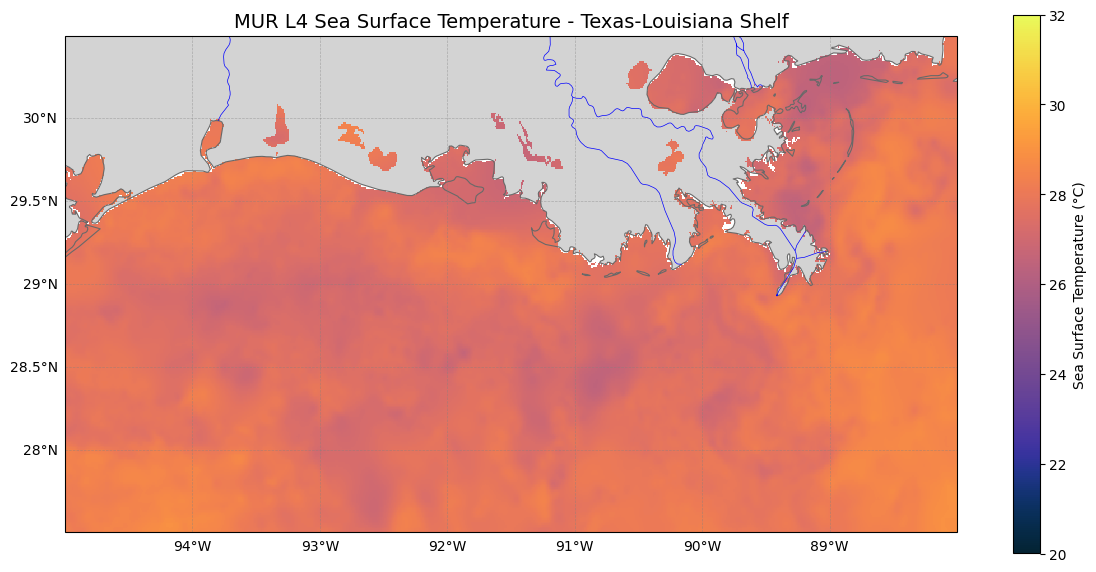


SST Statistics:
  Valid data points: 157958
  Mean SST: 27.75 °C
  Min SST: 26.36 °C
  Max SST: 28.97 °C
  Standard deviation: 0.47 °C


In [40]:
if sst_data is not None:
    # Extract data
    sst_plot = sst_data['sst_celsius']
    lat_plot = sst_data['lat']
    lon_plot = sst_data['lon']

    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    ax.set_aspect(1.3, adjustable='box', anchor='C')
    
    # Define SST color range
    sst_vmin, sst_vmax = 20, 32
    
    # Plot SST
    sst_mesh = ax.pcolormesh(
        lon_plot, lat_plot, np.squeeze(sst_plot),
        cmap=cmocean.cm.thermal, shading='auto',
        vmin=sst_vmin, vmax=sst_vmax,
        transform=ccrs.PlateCarree()
    )
    
    # Add map features (consistent with CDOM styling)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='dimGray')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimGray')
    ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
    
    # Add gridlines
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    
    # Colorbar + title
    plt.colorbar(sst_mesh, label='Sea Surface Temperature (°C)', shrink=0.7)
    plt.title('MUR L4 Sea Surface Temperature - Texas-Louisiana Shelf', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    print(f"\nSST Statistics:")
    print(f"  Valid data points: {np.sum(~np.isnan(sst_plot))}")
    print(f"  Mean SST: {np.nanmean(sst_plot):.2f} °C")
    print(f"  Min SST: {np.nanmin(sst_plot):.2f} °C")
    print(f"  Max SST: {np.nanmax(sst_plot):.2f} °C")
    print(f"  Standard deviation: {np.nanstd(sst_plot):.2f} °C")
else:
    print("No SST data available for visualization.")